# Opioid Death Analysis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as st
from scipy.stats import linregress
import folium
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

In [2]:
#Create overall dataframe
wide_data = "Wide_Master.csv"
wide_master = pd.read_csv(wide_data, usecols = ['State','Year','Total','Income','Unemployment','GDP Total','Population'])
wide_master = wide_master.rename(columns={
    "Total":"Death",
    "GDP Total": "GDP"})
wide_master['Deaths Per Capita'] = (wide_master['Death']/wide_master['Population'])*100

# Drop "NA" in the dataset
wide_master2 = wide_master.dropna(how='any')

# Factor: State

In [3]:
#Summary statistics of mean death rate by state
mean_total = wide_master2.groupby("State")["Deaths Per Capita"].mean()
median_total = wide_master2.groupby("State")["Deaths Per Capita"].median()
stdv_total = wide_master2.groupby("State")["Deaths Per Capita"].std()
deathsummary_df = pd.DataFrame({"Mean Deaths Per Capita by State": mean_total, 
                                "Median Deaths Per Capita by State": median_total,  
                                "Standard Deviation Deaths Per Capita by State": stdv_total,
                          })
deathsummary_df.sort_values(by="Mean Deaths Per Capita by State", ascending=False).head()

,Mean Deaths Per Capita by State,Median Deaths Per Capita by State,Standard Deviation Deaths Per Capita by State
State,,,
West Virginia,0.044854,0.041499,0.023336
Kentucky,0.030316,0.023732,0.019663
New Mexico,0.024269,0.018824,0.018183
Wyoming,0.019768,0.019768,0.010631
Utah,0.018185,0.015086,0.011544


In [7]:
#Create dataframe of mean death rate by state
meandeath_df = pd.DataFrame({"Mean Death by State": mean_total
                            })


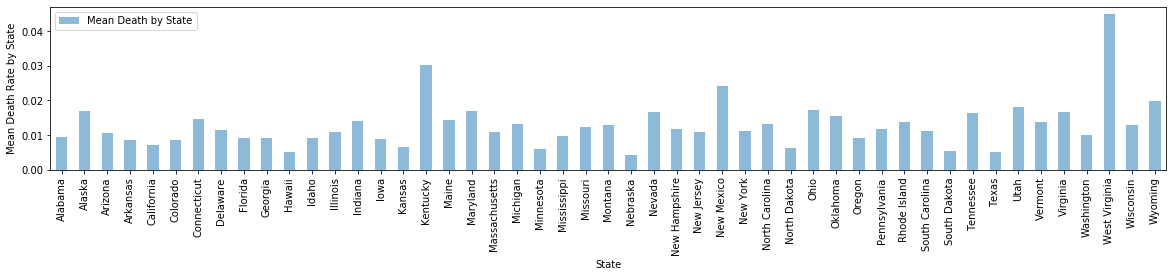

<Figure size 432x288 with 0 Axes>

In [9]:
#Bar graph of mean death rate by state
chart = meandeath_df.plot(kind='bar', alpha=0.5, align="center",figsize=(20,3))
chart.set_xlabel("State")
chart.set_ylabel("Mean Death Rate by State")

plt.savefig("Visualizations/Bar_Mean_Death_By_State.png")
plt.show()
plt.tight_layout()

In [11]:
#Summary statistics of mean, meadian and standard deviation of death rate by state
mean_income = wide_master2.groupby("State")["Income"].mean()
median_income = wide_master2.groupby("State")["Income"].median()
stdv_income = wide_master2.groupby("State")["Income"].std()
incomesummary_df = pd.DataFrame({
       "Mean Income by State": mean_income, 
       "Median Income Rate by State": median_income, 
       "Standard Deviation Income by State": stdv_income
       })
meanincome_df = pd.DataFrame({"Mean Income by State": mean_income
                            })                        

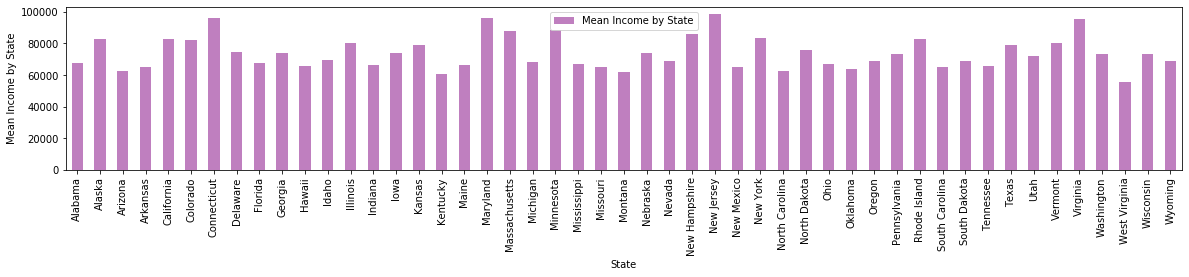

<Figure size 432x288 with 0 Axes>

In [12]:
#Bar graph of mean income by state
chart = meanincome_df.plot(kind='bar',color='purple', alpha=0.5, align="center",figsize=(20,3))
chart.set_xlabel("State")
chart.set_ylabel("Mean Income by State")


plt.show()
plt.tight_layout()

In [13]:
#Create state dataframe for choropleth map
state_data_grp = wide_master2.groupby("State")["Deaths Per Capita"].mean()
statedata_df = pd.DataFrame({"Mean Death by State": state_data_grp})
statedata_df = statedata_df.reset_index()

In [14]:
#Mean Death rate by state choropleth map

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=statedata_df,
    columns=['State', 'Mean Death by State'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Opioid Death Rate (%)'
).add_to(m)

folium.LayerControl().add_to(m)
m


#Observation: Louisiana hardest hit, followed by West Virginia. 
#This is important to consider when implementing targeted interventions

<Figure size 432x288 with 0 Axes>

In [15]:
# Top 5 states with the highest average death rate per capita from 2011 to 2017 
state_death = wide_master2.groupby("State").agg({
    "Deaths Per Capita": "mean",
}).reset_index()

state_death.sort_values(by="Deaths Per Capita",ascending=False).head(5)

,State,Deaths Per Capita
46,West Virginia,0.044854
16,Kentucky,0.030316
29,New Mexico,0.024269
48,Wyoming,0.019768
42,Utah,0.018185


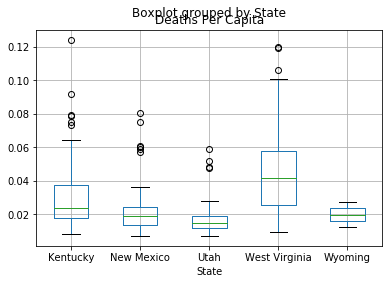

In [16]:
# Boxplot of the those top 5 states 
top5states = wide_master2.loc[
    (wide_master2["State"] == "West Virginia") | 
    (wide_master2["State"] == "Kentucky") | 
    (wide_master2["State"] == "New Mexico") | 
    (wide_master2["State"] == "Wyoming") | 
    (wide_master2["State"] == "Utah") 
    ]
top5states.boxplot("Deaths Per Capita", by="State")
plt.savefig("Visualizations/Boxplot_Deaths_Per_Capita_By_State.png")

In [17]:
# Ordinary Least Squares (OLS) model analyzing only the TOP 5 states by deaths per capita
# Death ~ State Conclusion: Since the p-value is less than 0.05, we reject the null hypothesis and conclude that significant difference does exist in the death rates by state. 
model_top5 = ols('Death ~ State', data=top5states).fit()
anova_table_top5 = sm.stats.anova_lm(model_top5, typ=2)
anova_table_top5

,sum_sq,df,F,PR(>F)
State,32187.721726,4.0,8.223861,0.000003
Residual,287674.786635,294.0,NaN,NaN


In [18]:
# Ordinary Least Squares (OLS) model analyzing all the states 
# Death ~ State Conclusion: Since the p-value is less than 0.05, we reject the null hypothesis and conclude that significant difference does exist in the death rates by state. 
model_all = ols('Death ~ State', data=wide_master2).fit()
anova_table_all = sm.stats.anova_lm(model_all, typ=2)
anova_table_all

,sum_sq,df,F,PR(>F)
State,9.424557e+05,48.0,7.482929,4.111790e-46
Residual,8.317779e+06,3170.0,NaN,NaN


# Factor: Year

In [19]:
# Total number of death by year 
year_death = wide_master2.groupby("Year").agg({
    "Death": "sum"
}).reset_index()
year_death

,Year,Death
0,2011,14029.0
1,2012,14276.0
2,2013,15997.0
3,2014,18544.0
4,2015,21007.0
5,2016,24659.0
6,2017,24336.0


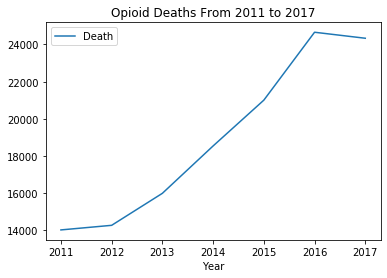

In [20]:
# Line plot of death by year
year_death.plot(kind="line", x="Year", y="Death", title="Opioid Deaths From 2011 to 2017")
plt.savefig("Visualizations/Line_Deaths_Overtime.png")
#Observation: 2016 had the largest number of death; increasing trend. 

In [21]:
# Death ~ Year Conclusion: Since the p-value is less than 0.05, we reject the null hypothesis and conclude that significant difference does exist in the death rates by year. 
year_vs_death = smf.ols('Death ~ Year', data=wide_master2).fit()
print(year_vs_death.summary())

                            OLS Regression Results                            
Dep. Variable:                  Death   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     17.93
Date:                Tue, 24 Mar 2020   Prob (F-statistic):           2.35e-05
Time:                        21:22:20   Log-Likelihood:                -17377.
No. Observations:                3219   AIC:                         3.476e+04
Df Residuals:                    3217   BIC:                         3.477e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4014.5620    957.700     -4.192      0.0

# Factor: GDP

In [22]:
#Create dataframe for GDP Total
wide_master3 = pd.read_csv(wide_data, usecols = ['State','GDP Total'])
wide_master3 = wide_master3.dropna(how='any')
mean_GDP = wide_master3.groupby("State")["GDP Total"].mean()
GDPsummary_df = pd.DataFrame({"Mean GDP by State": mean_GDP
                             })

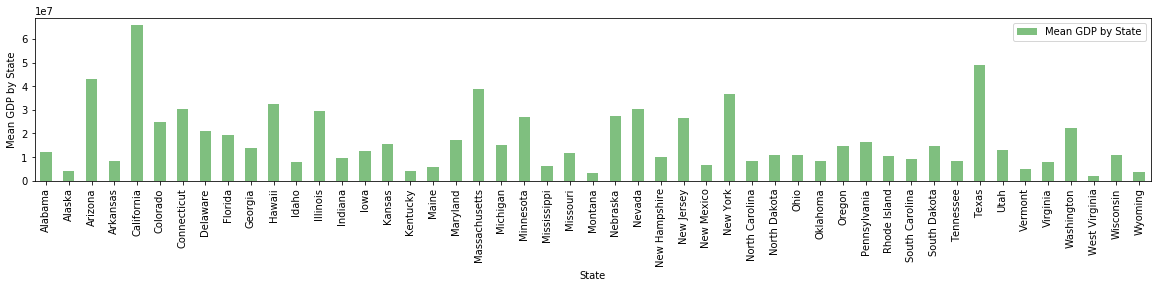

<Figure size 432x288 with 0 Axes>

In [23]:
#Bar graph of GDP by state
chart = GDPsummary_df.plot(kind='bar',color='green', alpha=0.5, align="center",figsize=(20,3))
chart.set_xlabel("State")
chart.set_ylabel("Mean GDP by State")

plt.savefig("Visualizations/Bar_Mean_GDP_By_State.png")
plt.show()
plt.tight_layout()

In [24]:
# Death ~ GDP Conclusion: Since the p-value is less than 0.05, we reject the null hypothesis and conclude that significant difference does exist in the death rates by GDP. 
gdp_vs_death = smf.ols('Death ~ GDP', data=wide_master2).fit()
print(gdp_vs_death.summary())

                            OLS Regression Results                            
Dep. Variable:                  Death   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     2161.
Date:                Tue, 24 Mar 2020   Prob (F-statistic):               0.00
Time:                        21:22:29   Log-Likelihood:                -16559.
No. Observations:                3219   AIC:                         3.312e+04
Df Residuals:                    3217   BIC:                         3.313e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.0617      0.810     30.930      0.0

# Factor: Population Size and Education Level

In [25]:
# Death ~ Population Conclusion: Since the p-value is less than 0.05, we reject the null hypothesis and conclude that significant difference does exist in the death rates by population size. 
population_vs_death = smf.ols('Death ~ Population', data=wide_master).fit()
print(population_vs_death.summary())

                            OLS Regression Results                            
Dep. Variable:                  Death   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     3555.
Date:                Tue, 24 Mar 2020   Prob (F-statistic):               0.00
Time:                        21:22:31   Log-Likelihood:                -17461.
No. Observations:                3468   AIC:                         3.493e+04
Df Residuals:                    3466   BIC:                         3.494e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.2553      0.748     23.061      0.0

In [26]:
#Create dataframe of population and grad degrees 
wide_master4 = pd.read_csv(wide_data, usecols = ['State','Population','Bachelor_Degree', 'Grad_Degree','HS_Grad','Less_Than_HS','Associates_Degree'])
wide_master4 = wide_master4.dropna(how='any')

In [27]:
#Create dataframe of the total number of people in each education level
sum_population = wide_master4.groupby("State")["Population"].sum()
sum_Bachelor = wide_master4.groupby("State")["Bachelor_Degree"].sum()
sum_Grad = wide_master4.groupby("State")["Grad_Degree"].sum()
sum_HS = wide_master4.groupby("State")["HS_Grad"].sum()
sum_LessHS = wide_master4.groupby("State")["Less_Than_HS"].sum()
sum_Associates = wide_master4.groupby("State")["Associates_Degree"].sum()

degreesummary_df = pd.DataFrame({"Total of Population by State": sum_population,
                                 "Total of Graduate Degree by State": sum_Grad, 
                                 "Total of Bachelor Degree by State": sum_Bachelor, 
                                 "Total of Associates Degree by State": sum_Associates,
                                 "Total of High School Degree by State": sum_HS, 
                                 "Total of Less Than HS Degree by State": sum_LessHS,
                              
                          })

In [28]:
# Education level of the top 2 and bottom 2 states by death per capita. Top 2 states: WV and KY, bottom 2 states: TX and CA
PieData = degreesummary_df.loc[['West Virginia','Kentucky','Texas','California'],:]
percent_Bachelor = PieData["Total of Bachelor Degree by State"]/PieData["Total of Population by State"]
percent_Grad = PieData["Total of Graduate Degree by State"]/PieData["Total of Population by State"]
percent_HS = PieData["Total of High School Degree by State"]/PieData["Total of Population by State"]
percent_LessHS = PieData["Total of Less Than HS Degree by State"]/PieData["Total of Population by State"]
percent_Associates = PieData["Total of Associates Degree by State"]/PieData["Total of Population by State"]
percent_other = 1-percent_Bachelor - percent_Grad - percent_HS - percent_LessHS - percent_Associates
percentdegree_df = pd.DataFrame({"Percentage of Graduate Degree by State": percent_Grad, 
                                 "Percentage of Bachelor Degree by State": percent_Bachelor, 
                                 "Percentage of Associates Degree by State": percent_Associates,
                                 "Percentage of High School Degree by State": percent_HS, 
                                 "Percentage of Less Than HS Degree by State": percent_LessHS,
                                 "Percentage of Others": percent_other
                          })
percentdegree_df.style.format("{:.2%}")

,Percentage of Graduate Degree by State,Percentage of Bachelor Degree by State,Percentage of Associates Degree by State,Percentage of High School Degree by State,Percentage of Less Than HS Degree by State,Percentage of Others
State,,,,,,
West Virginia,5.57%,8.58%,17.95%,27.10%,10.50%,30.30%
Kentucky,7.17%,10.52%,19.31%,20.17%,9.06%,33.78%
Texas,6.27%,12.01%,17.24%,13.86%,10.79%,39.83%
California,7.48%,12.77%,18.87%,13.23%,11.83%,35.82%


In [29]:
#Setup pie charts for grad degrees of WV, KY, TX, and CA. 
pie_wv = percentdegree_df.loc['West Virginia',:]
wv_df = pd.DataFrame(pie_wv)
pie_ken = percentdegree_df.loc['Kentucky',:]
ken_df = pd.DataFrame(pie_ken)
pie_tx = percentdegree_df.loc['Texas',:]
tx_df = pd.DataFrame(pie_tx)
pie_cal = percentdegree_df.loc['California',:]
cal_df = pd.DataFrame(pie_cal)

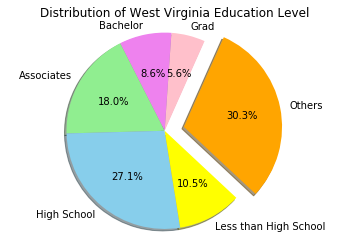

In [30]:
# Distribution of West Virginia Education Level
explode = (0,0,0,0,0,0.2)
colors = ["pink", "violet","lightgreen","skyblue","yellow","orange"]
plt.pie(wv_df,labels=["Grad","Bachelor","Associates","High School","Less than High School","Others"],autopct="%1.1f%%",explode=explode,colors=colors,shadow=True, startangle=66)
plt.axis("equal")
plt.title("Distribution of West Virginia Education Level")
plt.savefig("Visualizations/Pie_WV_Education_Level.png")
plt.show()

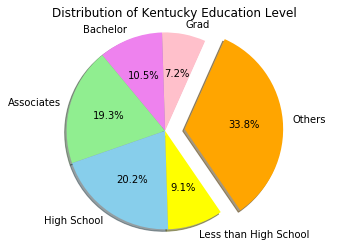

In [31]:
# Distribution of Kentucky Education Level
explode = (0,0,0,0,0,0.2)
colors = ["pink", "violet","lightgreen","skyblue","yellow","orange"]
plt.pie(ken_df,labels=["Grad","Bachelor","Associates","High School","Less than High School","Others"],autopct="%1.1f%%",explode=explode,colors=colors,shadow=True, startangle=66)
plt.axis("equal")
plt.title("Distribution of Kentucky Education Level")
plt.savefig("Visualizations/Pie_KY_Education_Level.png")
plt.show()

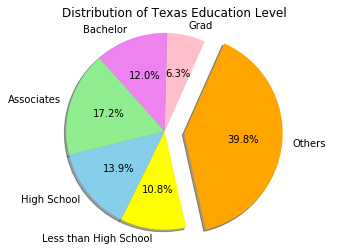

In [32]:
# Distribution of Texas Education Level
explode = (0,0,0,0,0,0.2)
colors = ["pink", "violet","lightgreen","skyblue","yellow","orange"]
plt.pie(tx_df,labels=["Grad","Bachelor","Associates","High School","Less than High School","Others"],autopct="%1.1f%%",explode=explode,colors=colors,shadow=True, startangle=66)
plt.axis("equal")
plt.title("Distribution of Texas Education Level")
plt.savefig("Visualizations/Pie_TX_Education_Level.png")
plt.show()

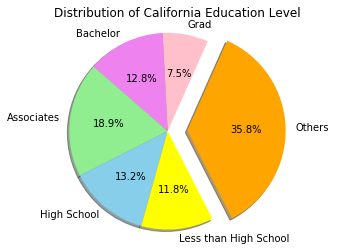

In [33]:
# Distribution of California Education Level
explode = (0,0,0,0,0,0.2)
colors = ["pink", "violet","lightgreen","skyblue","yellow","orange"]
plt.pie(cal_df,labels=["Grad","Bachelor","Associates","High School","Less than High School","Others"],autopct="%1.1f%%",explode=explode,colors=colors,shadow=True, startangle=66)
plt.axis("equal")
plt.title("Distribution of California Education Level")
plt.savefig("Visualizations/Pie_CA_Education_Level.png")
plt.show()

# Factor: Income

In [34]:
#Creating bins for income
income_bins = [0, 35000, 75000, 120000, 165000]
group_names = ["<$35K", "$35K-$75K", "$75K-120K", "$115K-165K"]

In [35]:
pd.cut(wide_master2["Income"], income_bins, labels=group_names).head()

0    $35K-$75K
3    $35K-$75K
4    $75K-120K
5    $35K-$75K
6    $75K-120K
Name: Income, dtype: category
Categories (4, object): [<$35K < $35K-$75K < $75K-120K < $115K-165K]

In [36]:
#Place the data series into a new column inside of the DataFrame
wide_master2["Income Ranges"] = pd.cut(wide_master2["Income"], income_bins, labels=group_names)

In [37]:
# Create a GroupBy object based upon "Income Ranges"
income_death_mean = wide_master2.groupby("Income Ranges")["Deaths Per Capita"].mean()
income_death_median = wide_master2.groupby("Income Ranges")["Deaths Per Capita"].median()
income_death_sd = wide_master2.groupby("Income Ranges")["Deaths Per Capita"].std()

#Put into dataframe
income_deathsummary_df = pd.DataFrame({"Mean Death Rate by Income": income_death_mean, 
                                       "Median Death Rate by Income": income_death_median,  
                                       "Standard Deviation Death Rate by Income": income_death_sd, 
                          })
income_deathsummary_df
#Observation: Lower income seems to have higher sum stats

,Mean Death Rate by Income,Median Death Rate by Income,Standard Deviation Death Rate by Income
Income Ranges,,,
<$35K,0.082850,0.067063,0.036426
$35K-$75K,0.015639,0.012401,0.012628
$75K-120K,0.010322,0.008693,0.006477
$115K-165K,0.006745,0.006369,0.003449


In [38]:
#Create dataframe of mean death rate by income ranges
income_death_mean_df = pd.DataFrame({"Mean Death Rate by Income": income_death_mean})

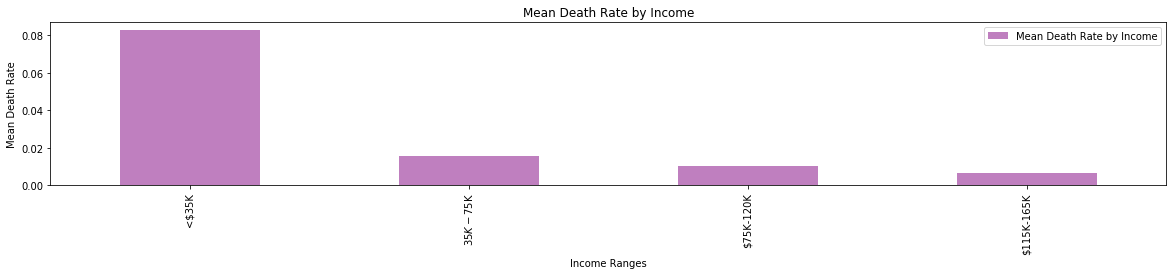

<Figure size 432x288 with 0 Axes>

In [39]:
#Bar chart of mean death rate by income rnages
chart = income_death_mean_df.plot(kind='bar',color='purple', alpha=0.5, align="center",figsize=(20,3))
chart.set_xlabel("Income Ranges")
chart.set_ylabel("Mean Death Rate")
plt.title("Mean Death Rate by Income")

plt.savefig("Visualizations/Bar_Mean_Death_Rate_By_Income.png")
plt.show()
plt.tight_layout()
#Observation: Higher mean death rate in people with lower income. Mean death rate decreases with higher income 
#This may be a result of extended drug use (i.e., difficulty keeping employment) but is important to consider for targeted intervention

In [40]:
#Create dataframe of mean death rate by income
incomemean_total = wide_master2.groupby("Income")["Deaths Per Capita"].mean()
deathincomesummary_df = pd.DataFrame({"Mean Death Rate by Income": incomemean_total
                          })

The r-squared is: -0.3669957140120881


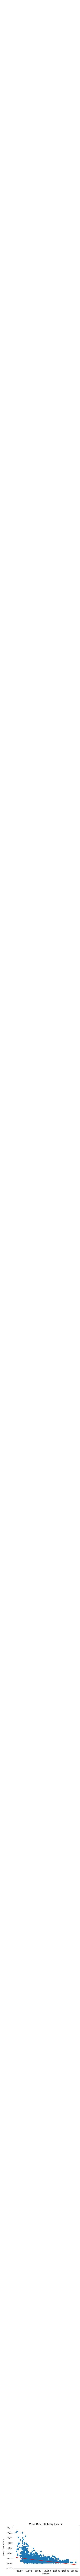

In [41]:
# Calculate the correlation coefficient and linear regression model of mean death rate by income
x_values = deathincomesummary_df.index
y_values = deathincomesummary_df["Mean Death Rate by Income"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel("Income")
plt.ylabel("Mean Death Rate")
plt.title("Mean Death Rate by Income")
print(f"The r-squared is: {rvalue}")
plt.savefig("Visualizations/Scatterplot_Mean_Death_Rate_vs_Income.png")
plt.show()
#Conclusion: Mean death rate and income shows a negative mild association with r-squared at -0.37
#This is consistent with the bar graph and demonstrates the relationship between high death rate and low income

In [42]:
# Death ~ Income Conclusion: Since the p-value is less than 0.05, we reject the null hypothesis and conclude that significant difference does exist in the death rates by income. 
income_vs_death = smf.ols('Death ~ Income', data=wide_master).fit()
print(income_vs_death.summary())

                            OLS Regression Results                            
Dep. Variable:                  Death   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     103.5
Date:                Tue, 24 Mar 2020   Prob (F-statistic):           5.61e-24
Time:                        21:24:28   Log-Likelihood:                -18698.
No. Observations:                3480   AIC:                         3.740e+04
Df Residuals:                    3478   BIC:                         3.741e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.2833      3.548      1.771      0.0

# Factor: Unemployment 

In [43]:
#Summary stats of unemployment by mean death rate 
mean_total = wide_master2.groupby("Unemployment")["Deaths Per Capita"].mean()
median_total = wide_master2.groupby("Unemployment")["Deaths Per Capita"].median()
stdv_total = wide_master2.groupby("Unemployment")["Deaths Per Capita"].std()
unemployment_deathsummary_df = pd.DataFrame({"Mean Death Rate by Unemployment": mean_total, 
                                             "Median Death Rate by Unemployment": median_total,  
                                             "Standard Deviation Death Rate by Unemployment": stdv_total, 
                          })

[Text(0, 0.5, 'Mean Death Rate'),
 Text(0.5, 0, 'Unemployment'),
 Text(0.5, 1.0, 'Mean Death Rate by Unemployment')]

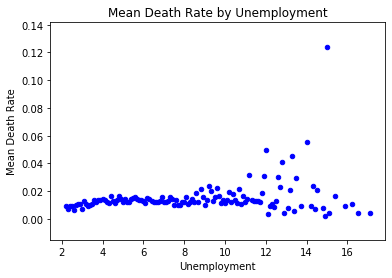

In [45]:
# Generate a scatter plot of mean death rate by unemployment
unemploymentdeath_scatter = pd.DataFrame({
    "x": unemployment_deathsummary_df.index,
    "y": unemployment_deathsummary_df["Mean Death Rate by Unemployment"]
})
unemploymentdeath_scatter.head()

fig, ax = plt.subplots()

unemploymentdeath_scatter.plot.scatter(x="x", y="y", ax=ax, color="blue")
ax.set(title="Mean Death Rate by Unemployment", xlabel="Unemployment", ylabel="Mean Death Rate")
#Observation: Mean death rate by unemployment shows a very mild positive association with peaks at high end unemployment
#This aligns with income and death rate relationship. Higher unemployment may be a result of extended drug use, 
    #but important to consider when implementing targeted interventions for the opioid epidemic

The r-squared is: 0.24339843184589507


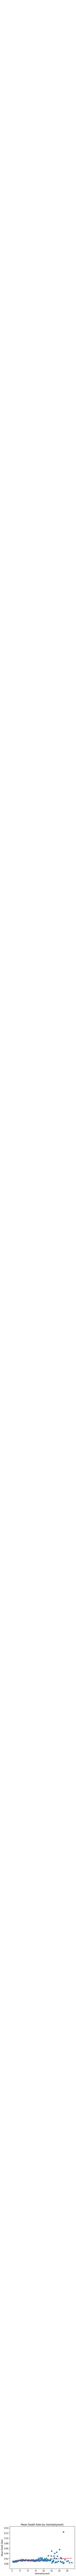

In [46]:
#Calculate the correlation coefficient and linear regression model
x_values = unemployment_deathsummary_df.index
y_values = unemployment_deathsummary_df["Mean Death Rate by Unemployment"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel("Unemployment")
plt.ylabel("Mean Death Rate")
plt.title("Mean Death Rate by Unemployment")
print(f"The r-squared is: {rvalue}")
plt.savefig("Visualizations/Scatterplot_Mean_Death_Rate_vs_Unemployment_fit_line.png")
plt.show()
#Conclusion: Shows a mild positive relationship between mean death rate and unemployment with r-squared of 0.24
#This demonstrates the relationship between high death rate and high unemployment

In [47]:
# Death ~ Unemployment Conclusion: Since the p-value is less than 0.05, we reject the null hypothesis and conclude that significant difference does exist in the death rates by unemployment. 
unemployment_vs_death = smf.ols('Death ~ Unemployment', data=wide_master).fit()
print(unemployment_vs_death.summary())

                            OLS Regression Results                            
Dep. Variable:                  Death   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     13.24
Date:                Tue, 24 Mar 2020   Prob (F-statistic):           0.000278
Time:                        21:25:18   Log-Likelihood:                -18290.
No. Observations:                3399   AIC:                         3.658e+04
Df Residuals:                    3397   BIC:                         3.660e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       50.0245      2.670     18.737   

# Prescription Specialty 

Drug overdoses account for a significant portion of deaths in United States. The majority of fatal drug overdoses involve opioids, a class of inhibitor molecules that disrupt transmission of pain signals through the nervous system. Medically, they are used as powerful pain relievers; however, they also produce feelings of euphoria. This makes them highly addictive and prone to abuse. The over dose would supress the respiration and can lead to Death.

Below Anlaysis would describe Physicians who precribe the Opioids in different streams of Speciality. This would give us an idea on which Speciality are using today the maximun opioid prescriptions. As of today we do not have a direct link to say how which speciality is causing highest Death rates But we do have the info as to how many these Drugs fall into which Speciality and the below graph would indirectly relate saying that internal medicine might having the highest death rates with Opioids today. The Prescriber.csv file has the Prescriber info along with the drugs that are prescribed by them. This csv file has the info on the Speciality the prescriber belong to. This is over the period of one year 2014.

In [48]:
# This gives the info on the Drugs that have opioids used in different Speciality
prescription_df = pd.read_csv("prescriber-info.csv")
series_counts = prescription_df["Specialty"].value_counts()
Specialty=[]

for i in series_counts.items():
    if i[1]>=500:
        Specialty.append(i[0])

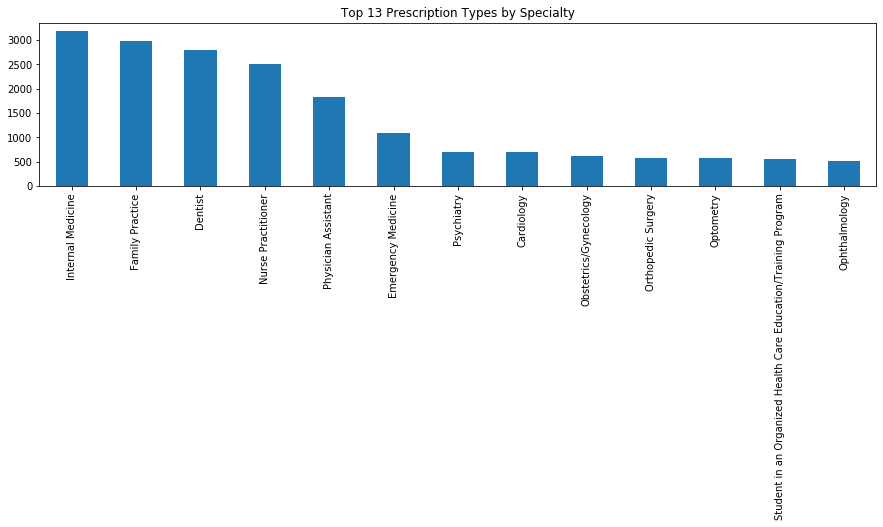

In [49]:
# This gives us the clear picture on which speciality would dispence the high number of Opioid drugs.
specialty_df=prescription_df[prescription_df["Specialty"].isin(Specialty)]["Specialty"]
specialty_df.value_counts().plot(kind='bar',figsize=(15, 3), title="Top 13 Prescription Types by Specialty")
plt.savefig("Visualizations/Bar_Specialty_Filtered.png")